### NSP Datasets

#### Setup the Envirnoment

Import necessary libaries.

In [ ]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

Download the original dataset from the [repository](https://github.com/SimoneCallegarin/NLP_project/blob/main/Data/EDOS_1M.csv)

In [35]:
csv_path_initial = "https://media.githubusercontent.com/media/simoCalle/NLP_Project_Datasets/main/EDOS_1M.csv"

In [36]:
df = pd.read_csv(csv_path_initial)

#### Dialogues Analysis

Analyze how dialogues are structured in the dataset in order to perform a better preprocessing phase.

In [ ]:
# Get the dialogue_id values for rows that occur only once
unique_dialogue_ids = df['dialogue_id'].value_counts()[df['dialogue_id'].value_counts() == 1].index.tolist()

# Filter the DataFrame to rows with unique dialogue_id values
unique_dialogue_id_rows = df[df['dialogue_id'].isin(unique_dialogue_ids)]

if len(unique_dialogue_id_rows) > 0:
    print("There are rows with unique dialogue_id values:")
    print(unique_dialogue_id_rows)
else:
    print("There are no rows with unique dialogue_id values (no dialogues with just 1 utterance).")

There are no rows with unique dialogue_id values (no dialogues with just 1 utterance).


In [ ]:
df['eb+_emot'].value_counts()[:7]

questioning      841556
furious          169917
acknowledging    138165
trusting         134197
wishing          108668
suggesting       101591
anticipating     100433
Name: eb+_emot, dtype: int64

Looking to the emotions distribution we can see that it is not homogeneous, due to a prevalence of *questioning* emotions.

Now let's see how many utterances per dialogues there are.

In [ ]:
max_turns = df.groupby('dialogue_id')['turn'].transform('max')

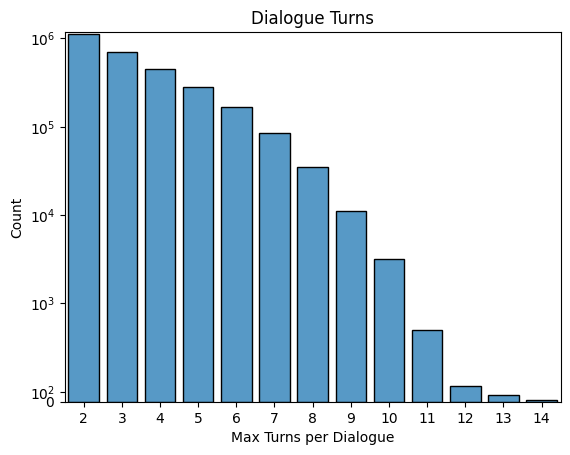

In [ ]:
sns.countplot(x=max_turns, facecolor='#5799C6', linewidth=1, edgecolor='black')
plt.xlabel('Max Turns per Dialogue')
plt.ylabel('Count')
plt.title('Dialogue Turns')
plt.yscale('symlog', linthresh=1000)
plt.show()

In [ ]:
max_turns.value_counts()

2     1112198
3      693840
4      444064
5      281300
6      164784
7       83636
8       34440
9       11043
10       3160
11        726
12        156
13         65
14         14
Name: turn, dtype: int64

It appears that the dataset contains mostly short dialogues.

#### Preprocessing

In [37]:
df_filtered = df

Remove dialogues that contains 2 or less utterances.

In [38]:
# Get the dialogue_id values where turn > 2
dialogues_longer_than_2 = df_filtered.loc[df_filtered['turn'] > 2, 'dialogue_id'].unique()

# Filter out the rows where turn <= 2 for each dialogue_id
df_filtered = df_filtered[df_filtered['dialogue_id'].isin(dialogues_longer_than_2)]

Reduce the number of dialogues containing 'questioning' utterances in order to make the distribution of the emotions more homogeneous.

In [39]:
# Select the number of dialogues containing questioning utterances to mantain
questioning_dialogues_to_mantain = 40000

In [40]:
# Get the dialogue_id values where eb+_emot == 'questioning'
questioning_dialogues = df_filtered.loc[df_filtered['eb+_emot'] == 'questioning', 'dialogue_id'].unique()

# Get the dialogue_id of the dialogues conatining 'questioning' that has to be removed
questioning_dialogues_to_remove = questioning_dialogues[:(len(questioning_dialogues)-questioning_dialogues_to_mantain)]

# Filter out the exceeding dialogues containing 'questioning' for each dialogue_id
df_filtered = df_filtered[~df_filtered['dialogue_id'].isin(questioning_dialogues_to_remove)]

# Reset the index of the filtered DataFrame
df_filtered = df_filtered.reset_index(drop=True)

In [41]:
df_filtered['eb+_emot'].value_counts()[:7]

questioning      67362
furious          48993
trusting         35149
acknowledging    34734
wishing          31575
suggesting       26730
anticipating     25109
Name: eb+_emot, dtype: int64

Now the distribution looks more uniform.

#### Split Dialogues into Two Senteces

In [42]:
final_df = df_filtered[['dialogue_id','turn','uttr']]

Split each dialogue in two sentences:
- the first will contain the first half of the utterances
- the second will have the second half of the utterances

In [43]:
# Store the number of turns of each dialogue
max_turns = final_df.groupby('dialogue_id')['turn'].transform('max')

# Create the datasets
first_half = final_df.loc[final_df['turn'] <= (max_turns+1)//2, ['dialogue_id','turn', 'uttr']]
second_half = final_df.loc[~(final_df.index.isin(first_half.index)), :]

In [44]:
first_half = first_half.reset_index(drop=True)
first_half

,dialogue_id,turn,uttr
0,217,1,Your medicine . Open your mouth .
1,217,2,Granny ...
2,500,1,"Hi there , Welcome to the Stockroom ."
3,500,2,I don 't really work here . I 've never even b...
4,675,1,I 'm gonna fuckin ' kill him . Wait your turn .
...,...,...,...
351031,8820571,1,Trying to force a nun back to the convent when...
351032,8820571,2,That seems to be your game . What 's that supp...
351033,8820621,1,Well .. .. this is just the way it was suppose...
351034,8820621,2,"Well then , great ."


In [45]:
second_half = second_half.reset_index(drop=True)
second_half

,dialogue_id,turn,uttr
0,217,3,Don 't spill it .
1,500,3,Don 't get me wrong . I 'm not a prude . I lik...
2,500,4,Shut up bitch ! Show us the butt plugs . Butt ...
3,675,3,"You motherfucker ! No , no ! Hold on ! What th..."
4,753,3,So I thought to myself ... I didn 't understan...
...,...,...,...
232583,8820065,4,Maybe . I think it would be better not to die .
232584,8820065,5,"Don 't you , doctor ?"
232585,8820571,3,"Well , for example , right now , by the nature..."
232586,8820621,4,It 's negative ?


##### Check the Correctness

Check if the number of dialogues in the starting dataframe and in the other two that have been producedd is the same.

In [46]:
len(final_df['dialogue_id'].unique()) == len(first_half['dialogue_id'].unique()) == len(second_half['dialogue_id'].unique())

True

Now let's see how the algorithm works with an example using the dialogue with more turns.

In [48]:
max_turn = final_df['turn'].max()
max_turn

13

In [49]:
row_with_max_turn = final_df.loc[final_df['turn'] == max_turn]

In [50]:
row_with_max_turn

,dialogue_id,turn,uttr
227854,2848381,13,I believe in children eating Their breakfast a...
553527,7010226,13,Why did you come ?


In [51]:
first_dialogue = first_half.loc[first_half['dialogue_id'] == row_with_max_turn['dialogue_id'].values[0]]
first_dialogue

,dialogue_id,turn,uttr
139339,2848381,1,"Good morning , father ."
139340,2848381,2,"Good morning , Darling ."
139341,2848381,3,"Good morning , Aunt Josephine ."
139342,2848381,4,"Good morning , Kitty ."
139343,2848381,5,"Good morning , Lawrence ."
139344,2848381,6,"Goodbye , Aunt josephine ."
139345,2848381,7,"Goodbye , Kitty . Have a good time ."


In [52]:
second_dialogue = second_half.loc[second_half['dialogue_id'] == row_with_max_turn['dialogue_id'].values[0]]
second_dialogue

,dialogue_id,turn,uttr
88503,2848381,8,I will !
88504,2848381,9,Take good care Of yourself !
88505,2848381,10,I will !
88506,2848381,11,"Goodbye , darling ! Goodbye !"
88507,2848381,12,"Must we have A draft , Henry ?"
88508,2848381,13,I believe in children eating Their breakfast a...


The algorithm correctly split the dialogue into two parts, exactly in half.

####  Generate a Dataframe with other Random Dialogues 

From the original dataset we produced a dataframe containing all the other dialogues that were not involved in the *first_sentences* and *second_sentences* dataframes.

In [107]:
# Get the dialogue_id values for rows that occur only once
taken_dialogues = final_df['dialogue_id'].unique()

# Filter the DataFrame to rows with unique dialogue_id values
wrong_sentences = df[~df['dialogue_id'].isin(taken_dialogues)]

##### Preprocess

In [73]:
wrong_sentences['eb+_emot'].value_counts()[:7]

questioning      774194
furious          120924
acknowledging    103431
trusting          99048
wishing           77093
anticipating      75324
suggesting        74861
Name: eb+_emot, dtype: int64

The distribution of the emotions over this dataset is quite unbalanced, so as before, we filter out some dialogues that contains the *questioning* emotion.

In [108]:
questioning_dialogues_to_mantain = 65000

In [109]:
# Get the dialogue_id values where eb+_emot == 'questioning'
questioning_dialogues = wrong_sentences.loc[wrong_sentences['eb+_emot'] == 'questioning', 'dialogue_id'].unique()

# Get the dialogue_id of the dialogues conatining 'questioning' that has to be removed
questioning_dialogues_to_remove = questioning_dialogues[:(len(questioning_dialogues)-questioning_dialogues_to_mantain)]

# Filter out the exceeding dialogues containing 'questioning' for each dialogue_id
wrong_sentences = wrong_sentences[~wrong_sentences['dialogue_id'].isin(questioning_dialogues_to_remove)]

# Reset the index of the filtered DataFrame
wrong_sentences = wrong_sentences.reset_index(drop=True)

In [110]:
wrong_sentences['eb+_emot'].value_counts()[:7]

questioning      84760
furious          58234
trusting         44940
acknowledging    43890
wishing          39806
anticipating     36286
suggesting       34432
Name: eb+_emot, dtype: int64

Now the distribution looks quite homogeneous.

##### Split the Utterances Randomly

For each dialogue we select the first randomic utterances in order to put them togheter next.

In [115]:
wrong_sentences = wrong_sentences.iloc[:len(first_sentences)][['dialogue_id','uttr']]

In [116]:
wrong_sentences

,dialogue_id,uttr
0,97,You moron ! What fool washes diapers by the we...
1,97,You useless fool !
2,99,How dare you sleep !
3,99,Up ! Go and clean the house .
4,100,Clean the kitchen .
...,...,...
162094,6583947,You like games ? You know what you are ? A bit...
162095,6583947,"Hands off ! Ah , shut up , Michel ."
162096,6583948,If you need me I 'm always here for you .
162097,6583948,My love .


#### Merge the utterances together

Let's now merge the utterances of the same dialogues togheter.

In [63]:
first_sentences = first_half.groupby('dialogue_id')['uttr'].agg(' '.join).reset_index()
second_sentences = second_half.groupby('dialogue_id')['uttr'].agg(' '.join).reset_index()
wrong_sentences = wrong_sentences.groupby('dialogue_id')['uttr'].agg(' '.join).reset_index()

In [64]:
first_sentences

,dialogue_id,uttr
0,76,Granny . Don 't tell anyone . Keep it . That '...
1,200,How about Oshin ? Oshin .
2,217,Your medicine . Open your mouth . Granny ...
3,355,"Sir , I 'd like some private moment with my mo..."
4,379,What the hell ? No one 's here . Dammit ! Chie...
...,...,...
162094,8820466,"There 's another . It 's not happy , exactly ...."
162095,8820525,"Minister , I really think I should sign as wel..."
162096,8820568,"Father , it 's God 's work . No , it is this w..."
162097,8820571,Trying to force a nun back to the convent when...


In [65]:
second_sentences

,dialogue_id,uttr
0,76,"Granny , thank you so much . Hey ! She 's ready ."
1,200,"Thank you , ma 'am !"
2,217,Don 't spill it .
3,355,Okay . Until midnight . Thank you .
4,379,So he did live here . Maybe he got tipped off ...
...,...,...
162094,8820466,Then let 's give it a try . You feel ready ? J...
162095,8820525,"Okay , Buckbeak . Come quickly . Come with us ..."
162096,8820568,"Yes , yes . God kept you here . He brought us ..."
162097,8820571,"Well , for example , right now , by the nature..."


In [67]:
wrong_sentences

,dialogue_id,uttr
0,1,"So , let 's take a look at what 's going on ar..."
1,53,Good for you ! That 's a big piece .
2,68,Is this rice ?
3,84,It 's breakfast time !
4,97,You moron ! What fool washes diapers by the we...
...,...,...
352747,8820579,Bring her back to him . Wow . It 's a miracle .
352748,8820594,"Okay , so we 're cool . We 're going to be gre..."
352749,8820596,"Check it out , the "" Chan-Chan Man "" !"
352750,8820631,"Wow , I can 't believe that 's our baby ."


Check the correctness of the dataframes produced: *first_sentences* and *second_sentences* must have an equal number of dialogues.

In [66]:
len(first_sentences) == len(second_sentences) == len(final_df['dialogue_id'].unique())

True

In [71]:
len(second_sentences)

162099

#### Build the final datasets

In [91]:
first_sentences = first_sentences.rename(columns={"uttr":"first_sentence"})
second_sentences = second_sentences.rename(columns={"uttr":"second_sentence"})
wrong_sentences = wrong_sentences.rename(columns={"uttr":"second_sentence"})

In [100]:
first_sentences.head()

,dialogue_id,first_sentence
0,76,Granny . Don 't tell anyone . Keep it . That '...
1,200,How about Oshin ? Oshin .
2,217,Your medicine . Open your mouth . Granny ...
3,355,"Sir , I 'd like some private moment with my mo..."
4,379,What the hell ? No one 's here . Dammit ! Chie...


In [93]:
second_sentences.head()

,dialogue_id,second_sentence
0,76,"Granny , thank you so much . Hey ! She 's ready ."
1,200,"Thank you , ma 'am !"
2,217,Don 't spill it .
3,355,Okay . Until midnight . Thank you .
4,379,So he did live here . Maybe he got tipped off ...


In [131]:
right_df = pd.concat([first_sentences.set_index('dialogue_id'), second_sentences.set_index('dialogue_id')],axis=1)
right_df['correlated']=1

In [132]:
right_df.head()

,first_sentence,second_sentence,correlated
dialogue_id,,,
76,Granny . Don 't tell anyone . Keep it . That '...,"Granny , thank you so much . Hey ! She 's ready .",1
200,How about Oshin ? Oshin .,"Thank you , ma 'am !",1
217,Your medicine . Open your mouth . Granny ...,Don 't spill it .,1
355,"Sir , I 'd like some private moment with my mo...",Okay . Until midnight . Thank you .,1
379,What the hell ? No one 's here . Dammit ! Chie...,So he did live here . Maybe he got tipped off ...,1


In [128]:
wrong_df = pd.concat([first_sentences, wrong_sentences],axis=1)[['first_sentence','second_sentence']]
wrong_df['correlated']=0

In [130]:
wrong_df

,first_sentence,second_sentence,correlated
0,Granny . Don 't tell anyone . Keep it . That '...,You moron ! What fool washes diapers by the we...,0
1,How about Oshin ? Oshin .,You useless fool !,0
2,Your medicine . Open your mouth . Granny ...,How dare you sleep !,0
3,"Sir , I 'd like some private moment with my mo...",Up ! Go and clean the house .,0
4,What the hell ? No one 's here . Dammit ! Chie...,Clean the kitchen .,0
...,...,...,...
162094,"There 's another . It 's not happy , exactly ....",You like games ? You know what you are ? A bit...,0
162095,"Minister , I really think I should sign as wel...","Hands off ! Ah , shut up , Michel .",0
162096,"Father , it 's God 's work . No , it is this w...",If you need me I 'm always here for you .,0
162097,Trying to force a nun back to the convent when...,My love .,0


Since we have a right version and a wrong version for each 'first sentence' in the dataset, if we shuffled them and random splitted in train and test, we could have data leakage because we could have some 'first sentences' in both sets and the model would be tested on data that it has already partially seen.
To solve this problem we are going to produce a train and a test set, where no 'first sentence' is in both sets.

In [148]:
test_percentage = 0.2
train_percentage = 1 - test_percentage
full_size = len(right_df)

In [152]:
right_df_train = right_df.iloc[:round(train_percentage*full_size)]
right_df_test = right_df.iloc[round(train_percentage*full_size):]

In [157]:
wrong_df_train = wrong_df.iloc[:round(train_percentage*full_size)]
wrong_df_test = wrong_df.iloc[round(train_percentage*full_size):]

In [160]:
nsp_df_train = pd.concat([right_df_train,wrong_df_train])
nsp_df_test = pd.concat([right_df_test,wrong_df_test])

#### Download the Resulting Datasets

In [161]:
nsp_df_train.to_csv('nsp_df_train.csv', index=False)
nsp_df_test.to_csv('nsp_df_test.csv', index=False)